# Movies:

This notebook is heavily influenced by [lesson6](https://course.fast.ai/videos/?lesson=6) of fast.ai course. Consider checking that out as well.

Equipped with the newly introduced mini-batch gradient descent we are ready to tackle some pretty interesting ways of applying ML. In this notebook we shall build a model from peoples movies ratings. We'll do something called *collaborative filtering*, however, the main focus is later in the unsupervised learning part where we try to categorize movies based on the newly greated latent factors of the movies.
***
#### What:
* PyTorch example on collaborative filtering in movie data set.
* Dimensional reduction for easier visualization of the clustering process. PCA, TSNE(?)
* Unsupervised learning (=clustering) in reduced dimensional movie latent factor space -> movies are put into categories based on user rating data, without additional reference togenre, etc..
* KMeans, DBScan, sklearn-clustering...
***



Lets see how collaborative filtering can be used to create a model of movies and imdb users using fastai. We further show the results using dimensional reduction and further apply clustering to extract movie genres. We do this without explicit reference to movie labels.

In [97]:
# Import the required libraries
import pandas as pd # Pandas deals with handling data. 
import numpy as np # Numpy provides a lot of FAST ways for array manipulation in python.
import matplotlib.pyplot as plt # Plotting script library
import matplotlib as mpl # Plotting
import seaborn as sns # More plotting

%matplotlib inline 
# Define some plotting params:
mpl.rcParams['figure.figsize'] = (12,6)
sns.set_style("whitegrid", {"axes.facecolor": ".99"})

### Start by importing sample of imdb movie dataset using fastai.

In [26]:
from fastai.collab import untar_data, URLs

path = untar_data(URLs.ML_100k)
print('The data is here: ', path)

ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])

# The file has weird encoding but pandas provides a way of changing it.
items = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', header=None, 
                    names=['movie', 'title', 'release date', 'video release date', 'IMDb URL', 
                           'unknown', 'Action', 'Adventure', 'Animation', "Children's", 
                           'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                           'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

ratings.head()

The data is here:  /home/jovyan/.fastai/data/ml-100k


,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [27]:
df = pd.merge(ratings, items, on='movie').drop(columns=['timestamp'])

# Fix the indexing for easier handling later..
df.user -= 1
df.movie -= 1

df.sort_values('user').head(10)

,user,movie,rating,title,release date,video release date,IMDb URL,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
43606,0,11,5,"Usual Suspects, The (1995)",14-Aug-1995,NaN,"http://us.imdb.com/M/title-exact?Usual%20Suspects,%20The%20(1995)",0,0,0,...,0,0,0,0,0,0,0,1,0,0
79998,0,253,1,Batman & Robin (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Batman+%26+Robin+(1997),0,1,1,...,0,0,0,0,0,0,0,0,0,0
35906,0,188,3,"Grand Day Out, A (1992)",01-Jan-1992,NaN,"http://us.imdb.com/M/title-exact?Grand%20Day%20Out,%20A%20(1992)",0,0,0,...,0,0,0,0,0,0,0,0,0,0
69127,0,86,5,Searching for Bobby Fischer (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Searching%20for%20Bobby%20Fischer%20(1993),0,0,0,...,0,0,0,0,0,0,0,0,0,0
51383,0,186,4,"Godfather: Part II, The (1974)",01-Jan-1974,NaN,"http://us.imdb.com/M/title-exact?Godfather:%20Part%20II,%20The%20(1974)",0,1,0,...,0,0,0,0,0,0,0,0,0,0
71026,0,179,3,Apocalypse Now (1979),01-Jan-1979,NaN,http://us.imdb.com/M/title-exact?Apocalypse%20Now%20(1979),0,0,0,...,0,0,0,0,0,0,0,0,1,0
97387,0,45,4,Exotica (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Exotica%20(1994),0,0,0,...,0,0,0,0,0,0,0,0,0,0
6611,0,200,3,Evil Dead II (1987),01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Evil%20Dead%20II%20(1987),0,1,1,...,0,0,1,0,0,0,0,0,0,0
36126,0,63,5,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,"http://us.imdb.com/M/title-exact?Shawshank%20Redemption,%20The%20(1994)",0,0,0,...,0,0,0,0,0,0,0,0,0,0
6751,0,240,4,"Last of the Mohicans, The (1992)",01-Jan-1992,NaN,"http://us.imdb.com/M/title-exact?Last%20of%20the%20Mohicans,%20The%20(1992)",0,1,0,...,0,0,0,0,0,1,0,0,1,0


Each movie rated by a user is a single row in the dataframe. Then one can check how many movies each user has rated and plot a histogram:

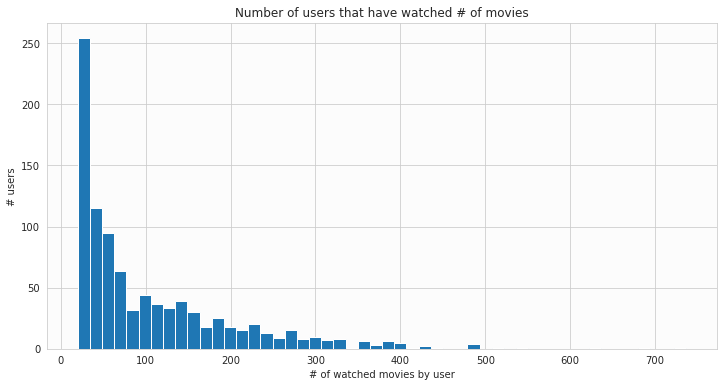

In [28]:
ax = df.loc[:, 'user'].value_counts().hist(bins=50)
ax.set_title('Number of users that have watched # of movies')
ax.set_xlabel('# of watched movies by user')
_ = ax.set_ylabel('# users')

Similarly we can chec the most popular movies:

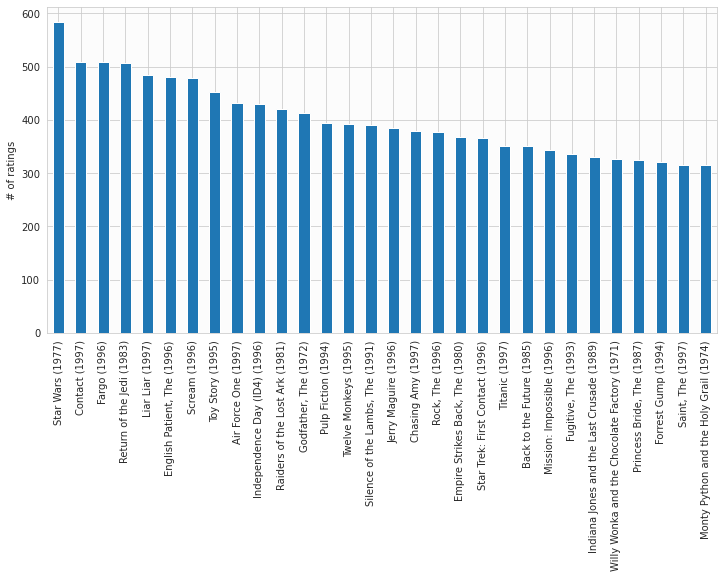

In [29]:
ax = df.loc[:, 'title'].value_counts().iloc[:30].plot.bar()
_ = ax.set_ylabel('# of ratings')

The rating of movies:

<AxesSubplot:xlabel='title'>

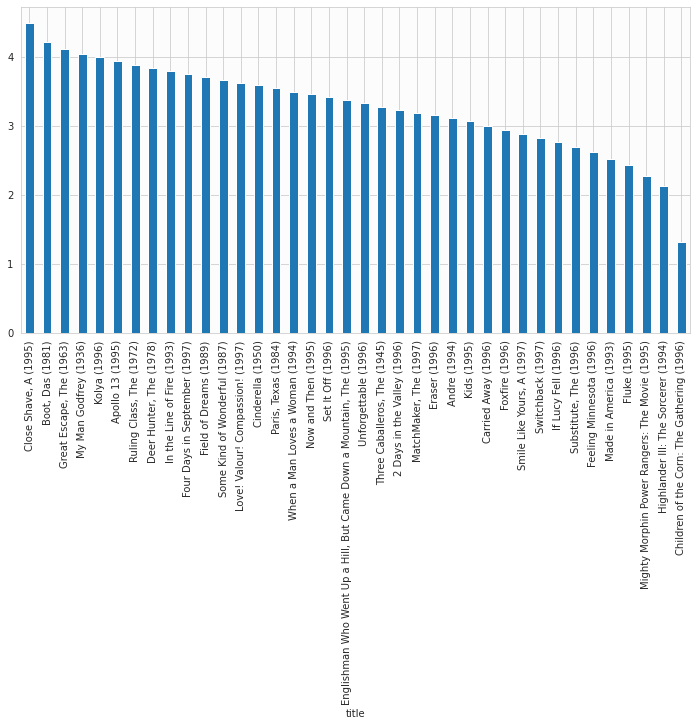

In [30]:
# First only pick movies which have more than 10 ratings:
tmp_ser = df.loc[:, 'movie'].value_counts() 
tmp_movies = tmp_ser.loc[tmp_ser > 10].index
mask = df.loc[:, 'movie'].isin(tmp_movies)

tmp_avg_rating = df.loc[mask].groupby('title').mean().loc[:, 'rating'].sort_values(ascending=False)[::30]
tmp_avg_rating.plot.bar()

### Lets build a training and validation sets.

In [31]:
# From each user pick a random movie - but make sure that movie reamins in train set as well:
valid_idxs = []
for u in df.user.unique():
    mask = u == df.user
    trial_idx = df.index[mask][3]
    valid_idxs.append(trial_idx)

    
df_valid = df.loc[np.array(valid_idxs), :].copy()
df_train = df.loc[~df.index.isin(np.array(valid_idxs)), :].copy()
df_train.shape, df_valid.shape

((99057, 26), (943, 26))

#### Lets pick the N most popular movies and M most active users:

In [32]:
nusers = 20
nmovies = 10
users = df_train.loc[:, 'user'].value_counts().iloc[:nusers].index
titles = df_train.loc[:, 'title'].value_counts().iloc[:nmovies].index
df_filtered = df_train.loc[df_train.user.isin(users) & df_train.title.isin(titles), :]

pd.pivot_table(df_filtered, index='user', columns='title', values='rating')

title,Air Force One (1997),Contact (1997),"English Patient, The (1996)",Fargo (1996),Independence Day (ID4) (1996),Liar Liar (1997),Raiders of the Lost Ark (1981),Return of the Jedi (1983),Scream (1996),Star Wars (1977)
user,,,,,,,,,,
6,4.0,4.0,4.0,5.0,5.0,1.0,5.0,3.0,4.0,5.0
12,1.0,4.0,3.0,5.0,5.0,2.0,4.0,5.0,1.0,5.0
91,NaN,4.0,NaN,5.0,5.0,3.0,5.0,4.0,3.0,5.0
93,NaN,5.0,4.0,5.0,2.0,NaN,4.0,4.0,3.0,5.0
180,3.0,3.0,1.0,3.0,4.0,2.0,NaN,NaN,4.0,NaN
233,3.0,2.0,3.0,4.0,NaN,3.0,3.0,3.0,3.0,4.0
275,4.0,5.0,NaN,5.0,4.0,4.0,5.0,5.0,4.0,5.0
278,NaN,NaN,NaN,4.0,4.0,2.0,4.0,3.0,3.0,3.0
292,2.0,3.0,3.0,4.0,3.0,2.0,5.0,3.0,3.0,5.0


## Task: find a way to predict a score user would give to a movie they have not seen (i.e., fill the nans)

Let us assume that each user can be described by a set of numbers $[f_{1i}, ... f_{Ni}]$, where $f_{ji}$ is the *latent factor* $j$ of user $i$. Furthermore assume similarly that a movie can be labeled by some other latent factors $[g_{1k},\ldots,g_{Nk}]$, where $g_{jk}$ is the *latent factor* $j$ of movie $k$. 

These latent factors could be viewed as, say preferences of a single user, and some properties (like genre) of a movie. Lets consider example user $U$ that strongly prefers western movies from the 70:ies over anything else, not bad taste! Lets denote for this user:

$\mathbf{f}_U = [f_{\text{western}}, f_{\text{70:ies}}, f_\text{scifi}] = [2, 2, 0]$,

Moreover, let us label our example movie $M$ by the same latent factors. We shall further assume that the example movies is "The good, the bad, and the ugly (1966)", then, 

$\mathbf{g}_M = [g_{\text{western}}, g_{\text{70:ies}}, g_\text{scifi}] = [1, .8, 0]$.

What would be the score given by user $U$ to movie $M$? We can figure out whatever, way of combining the above numbers but the simplest one is to take the innner product:

$R_{UM} = \mathbf{f}_U \cdot \mathbf{g}_M = \sum_i f_i g_i = 2\cdot 1 + 2 \cdot .8 + 0 \cdot 0 = 3.6$.

Let us now assume that each number in the above pivot table is a result of such scoring given by some *latent factors* of the movies and users. Let us then use pytorch to figure out the latent factors.

In [71]:
a = np.linspace(1,9,9).reshape(3,3)
b = np.linspace(9, 17, 9).reshape(3,3)

a, b, a*b, (a*b).sum(axis=1), a.dot(b) - a@b

(array([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]]),
 array([[ 9., 10., 11.],
        [12., 13., 14.],
        [15., 16., 17.]]),
 array([[  9.,  20.,  33.],
        [ 48.,  65.,  84.],
        [105., 128., 153.]]),
 array([ 62., 197., 386.]),
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]))

### Seek for latent factors using root mean squared loss and dot product score:

We shall now build our own class is able to perform mini-batch gradient descent w.r.t. a loss function that we define. We use pytorch for quick computations.

In [83]:
        
class DotProductScore(DotBase):
    
    def __init__(self, users_shape, movies_shape, X, use_bias=False, lr=.1):
        
        super().__init__(users_shape, movies_shape, X, use_bias, lr)
        
        
    def get_loss(self, users_movies_ratings):
        """
        Define a loss for your prediction. We know the true ratings given
        by users are stored in self.x[:, 2].
        """
        
        # Get the predictions:
        pred_rating = self.get_prediction(users_movies_ratings[:, :2])
        
        # Ratings are the thid column:
        ratings = users_movies_ratings[:, 2]
        
        # RMS loss:
        return ((pred_rating - ratings.flatten())**2).mean()
    
    def get_prediction(self, users_movies):
        """
        Use latent factors to produce a prediction of rating for given users and movies.
        """
        # User latent factors
        lat_users = self.lat_users[users_movies[:, 0]]
        # Movie latent factors
        lat_movies = self.lat_movies[users_movies[:, 1]]
        
        # Dot product between the latent factors -> prediction of the rating.
        score = (lat_users*lat_movies).sum(dim=1)
        
        # If we want to add bias to the prediction:
        if self.use_bias:
            # Biases are for movie and for user separately.
            score += self.bias_movies[users_movies[:, 1]] \
                   + self.bias_users[users_movies[:, 0]]
            
        return score

In [378]:
import torch 

nlatent = 3

# To init the DotScoreLearner:
#======================
nusers = df.user.nunique()
nmovies = df.movie.nunique()
use_bias = True
nepochs=100
cols = ['user', 'movie', 'rating']
X = torch.tensor(df_train.loc[:, cols].values)

dps = DotProductScore((nusers, nlatent), (nmovies, nlatent), X, use_bias, lr=.1)
#======================

# Opm loop:
#======================
print('Train Valid'.rjust(21))
for i in range(nepochs):
    # Update single epoch:
    loss = dps.update_lat()
    
    # Print results:
    if i%(nepochs//10) == 0:
        rms_train = loss.data.numpy()
        rms_valid = dps.get_loss(torch.tensor(df_valid.loc[:, cols].values)).data.numpy()
        print('Epoch {:02d}: {:.3f} {:.3f}'.format(i, rms_train, rms_valid))
        dps.save()


Not found
          Train Valid
Epoch 00: 3.163 2.381
Epoch 10: 1.593 1.054
Epoch 20: 1.407 0.936
Epoch 30: 1.266 0.902
Epoch 40: 1.150 0.889
Epoch 50: 1.049 0.872
Epoch 60: 0.957 0.857
Epoch 70: 0.874 0.852
Epoch 80: 0.800 0.849
Epoch 90: 0.732 0.849


### Create a helper dataframe movie_title_df:
It has all kinds of information of each movie available:

In [379]:
# Add the latent factor biases to the train dataframe. The latent factors can be 
# obtained by supplying the user/movie indices to the  dps.get_params() function.
df_train.loc[:, 'user_biases'] = dps.get_params(df_train.user.values)[1].detach().numpy()
df_train.loc[:, 'movie_biases'] = dps.get_params(df_train.movie.values, key='movie')[1].detach().numpy()

# Select only the movies from the train data:
movie_title_df = df_train.drop_duplicates(subset=['movie']).set_index('movie').sort_index()

# Add the count the movie is present in training set:
movie_title_df.loc[:, 'count'] = df_train.value_counts('movie').sort_index()

# add the mean rating of each movie:
movie_title_df.loc[:, 'avg_rating'] = [df_train.loc[df_train.loc[:, 'movie'] == mv, 'rating'].mean() for mv in movie_title_df.index]

#### Lets check the movies with large positive bias - these are expected to be the good movies...

In [380]:
movie_title_df.loc[:, ['title', 'movie_biases', 'count', 'avg_rating']].sort_values('movie_biases', ascending=False)[:15]

,title,movie_biases,count,avg_rating
movie,,,,
168,"Wrong Trousers, The (1993)",2.591598,118,4.466102
1448,Pather Panchali (1955),2.576004,8,4.625000
317,Schindler's List (1993),2.558753,298,4.466443
407,"Close Shave, A (1995)",2.551008,112,4.491071
482,Casablanca (1942),2.529547,242,4.454545
63,"Shawshank Redemption, The (1994)",2.522161,283,4.445230
113,Wallace & Gromit: The Best of Aardman Animation (1996),2.475526,67,4.447761
602,Rear Window (1954),2.444312,201,4.388060
49,Star Wars (1977),2.404490,583,4.358491


#### Worst movies (as given by the movie bias):

In [381]:
movie_title_df.loc[:, ['title', 'movie_biases', 'count', 'avg_rating']].sort_values('movie_biases', ascending=False)[-15:]

,title,movie_biases,count,avg_rating
movie,,,,
1660,"New Age, The (1994)",-0.220600,1,1.000000
313,3 Ninjas: High Noon At Mega Mountain (1998),-0.221997,5,1.000000
1617,King of New York (1990),-0.230465,1,1.000000
1492,"Modern Affair, A (1995)",-0.237368,1,1.000000
896,Time Tracers (1995),-0.252164,2,1.500000
1493,"Mostro, Il (1994)",-0.254627,1,1.000000
437,Amityville 3-D (1983),-0.254665,6,1.166667
1485,Girl in the Cadillac (1995),-0.263367,1,1.000000
1286,Ed (1996),-0.265635,6,1.333333


***
### Dimensional reduction (PCA):

Here we had, say $n$ latent factors. We might wonder is there a way to express the $\mathbf{f}\in \mathbb{R}^n$ in a lower dimensional space $\hat{\mathbf{f}} \in \mathbf{R}^l, ~ l\leq n $ by some lossy encoding (lossy because we do not expect to fully recover original $\mathbf{f}$ after encoding/decoding), however, so that we lose as little precision during the encoding/decoding process as possible. More formally, say we have encoding $e(\mathbf{f}) = \hat{\mathbf{f}}$ and decoding $d(\hat{\mathbf{f}})\approx \mathbf{f}$, we further define $r(\mathbf{f}) = d(e(\mathbf{f}))$. Let us again use the concept of loss function

$
L = \sum_{i\in \text{train},j} (f^{(i)}_j - r(\mathbf{f}^{(i)})_j)^2.
$

That is, we try to find mappings that, when you first encode and then decode, would minimize the distance between the decoded and original vector $\mathbf{f}$ and $ r(\mathbf{f})$.

Now the thing is that if you demand that the encoding and decodings are linear functions, i.e., matrix multiplications and you further introduce some additional constraints on those transformations - namely that the columns of transformation matrices ($\mathbf{D}$) are orthonormal, the loss $L$ can be minimized analytically and we find both the encoding $e(\mathbf{f}) = \mathbf{D}^\top\mathbf{f}$ and decoding $d(\mathbf{f}) = \mathbf{D}\mathbf{\hat{f}}$. This is called principal component analysis (PCA). The details are a bit beyond this course so we shall look at an example, for the interested [see 2.12](https://www.deeplearningbook.org/contents/linear_algebra.html). 

It turns out that the process extracts the directions in the training data with the most variance present. Say $l = 2 $ then the corresponding columns of $\mathbf{D}_{n \times 2}$ have the two perpendicular directions with the most of the variance in the training data. These are called the principal components. 

Here we need to note, that before applying PCA make **sure** that all your features have same scales - there is no point in performing pca if one of the feature ranges from zero to one being measured in percents while another is a time galactid distances in kilometers - the variance in the galactic distances will outrule any contributions from the 'percentage' feature! That is, if you do not have reason to believe that you ought to keep the scales of your features unchanged [standardize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) them, i.e., scale to zero mean and unit variance. 

Let us consider simple 2d case - we do not standardize here for demostration purposes; our features have same scales and are comparable (they are the number of apples and pears bough and each dot is a single customer in a supermarket. There are two types of people - those who like both apples and pears and those who only like apples... or something along those lines..):

[13.25941865  7.99690857]
[3.40449783 3.10897439]
[ 7.99489234 13.26852269]
[[ 0.56341666  0.8261729 ]
 [ 0.8261729  -0.56341666]]
13.268522685717324
[-0.8261729   0.56341666]
7.994892337204228
[0.56341666 0.8261729 ]


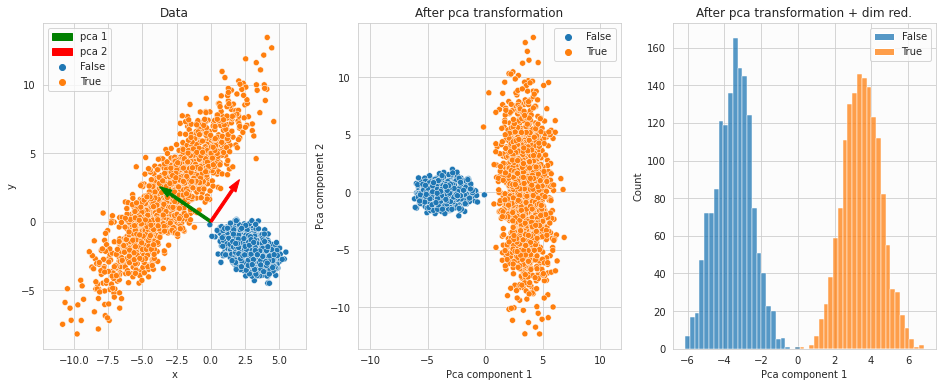

In [370]:
from sklearn.decomposition import PCA

standardize=False #True # 


N = 3000
D = 3.5 #*1000

# Create the data:
data=np.zeros((N, 2))
data[:N//2, 0] = np.random.normal(loc=D, size=N//2)
data[N//2:, 0] = np.random.normal(loc=-D, size=N//2)
data[:N//2, 1] = np.random.normal(loc=0, scale=.6, size=N//2)
data[N//2:, 1] = np.random.normal(loc=0, scale=4., size=N//2)

# Shift the mean:
data -= data.mean(axis=0)
if standardize: data /= data.std(axis=0)

# Imaginary classes:
cl = np.zeros(N, dtype=bool)
cl[N//2:] = 1

print(data.var(axis=0))

# Rotate the data:

# Rotation angle
phi = -np.pi/5

# Rotation matrix
R = np.array([[np.cos(phi), -np.sin(phi)],
              [np.sin(phi), np.cos(phi)]])

# Rotated_data:
data = (R@(data.T)).T

# Shift
data -= data.mean(axis=0)


print(data.std(axis=0))

# The principal components are the eigenvectors of the covariance matrix...
eig, eig_vec = np.linalg.eig(np.cov(data.T))
print(eig[eig.argsort()])
print(eig_vec[:, eig.argsort()])

# Use PCA to find the pricipal components:
pca = PCA(n_components=2).fit(data)

# Create the figure:
_, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))

# Original and components:
ax1 = sns.scatterplot(x=data[:, 0], y=data[:, 1], ax=ax1, hue=cl)
for i, color, expl_var, pca_comp in zip(range(2), ['g', 'r'], pca.explained_variance_, pca.components_):
    print(expl_var)
    print(pca_comp)
    ax1.arrow(0, 0, *(pca_comp*np.sqrt(expl_var)), width=.2, color=color, label='pca {}'.format(i+1))
ax1.set_title('Data')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend()
ax1.axis('equal')


# Transformed:
pca_data = pca.transform(data)
ax2 = sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], ax=ax2, hue=cl)
ax2.set_title('After pca transformation')
ax2.set_xlabel('Pca component 1')
ax2.set_ylabel('Pca component 2')
ax2.axis('equal')

# Dim reduced:
ax3 = sns.histplot(x=pca_data[:, 0], hue=cl, ax=ax3, bins=50)
#ax4 = sns.scatterplot(x=pca_data[:, 0], y=np.ones(N)*-1, hue=cl, ax=ax4)
ax3.set_title('After pca transformation + dim red.')
ax3.set_xlabel('Pca component 1')
plt.show()

Text(0, 0.5, 'exlpained variance ratio')

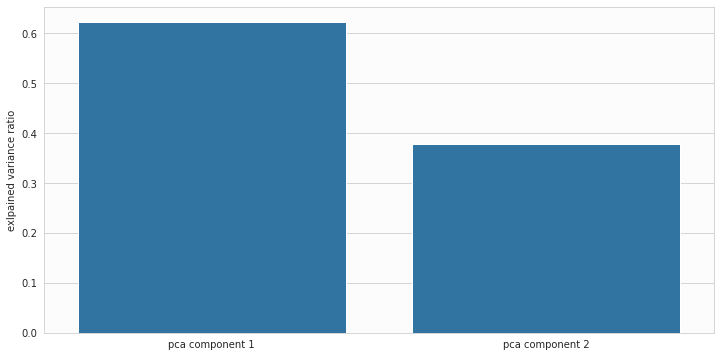

In [345]:
ax = sns.barplot(x=np.arange(2), y=pca.explained_variance_ratio_, color='C0')
ax.set_xticklabels(['pca component {}'.format(i) for i in [1,2]])
ax.set_ylabel('exlpained variance ratio')

Such encodings can be used in various ways. One of the uses of PCA is in noise reduction - you should get familiar with various dimensional reduction/encoding schemes... Unfortunately, we wont have the time nor cababilities go through these technigues further but have to just resort using the sklearn implementations of them. 
***
## Unsupervised Learning - Clustering:

Let us use PCA (and TSNE) to plot our encoded movie latent factors and see if we can find some movie genres from the resulting plots using clustering. Clustering is essentially an unsupervised learning method where the clustering method tries to identify items that it thinks belong together and thus form a *cluster*. See the above pca example image and you ought to spot two 'clusters'. There are obviously bunch of [ways](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster) how [clustering](https://scikit-learn.org/stable/modules/clustering.html) can be performed but there is an important thing to note. Clustering most often comes *after* dimensional reduction! (unless the method happens to work in higher dimensions??). This is because most of the clustering methods are based on some sort of **distance** metrics in assessing whether given items belong to same cluster, however, most distance metrics become unusable (and hence the whole concept of distance to nearest eightbor etc.) in high dimensional spaces is at best questionable. Namely as the number of dimensions increase all examples of the training data are more and more likely to be equally distant from each other. As a general remark, you should be aware of the [*curse of dimensionality*](https://en.wikipedia.org/wiki/Curse_of_dimensionality) since it it quite often present in various ml problems. More formal [reads](www.loria.fr/%7Eberger/Enseignement/Master2/Exposes/beyer.pdf) [here](https://bib.dbvis.de/uploadedFiles/155.pdf). 
***
### K-Means clustering:

[K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering is widely used and easy to describe. Like often before we do not bother much with the details, but for the sake of integrity we point out that again there is a loss that the K-Means algorhithm seeks to minimize. The loss is **within cluster sum of squared errors**

$
\text{SSE} = \sum_{i \in \text{train}} \sum_{j \in clusters} w^{(i,j)} | \mathbf{x}^{(i)} -  \mathbf{m}^{j}|^2,
$

here $w^{(i,j)} = 1$ only if item $\mathbf{x}^{(i)}$ is in cluster $j$, 0 otherwise. You should keep in mind that the chosen distance metric (squared eucledian distance) can become quite bad at separating items in high dimensional spaces (see earlier references) and hence K-means, even while applicable in whichever dimensional space (might) benefit from dimensional reduction preprocessing step. Note also that since distance is used to pick items to given cluster - the features should have same scales. Othervise the feature with largest scale will dominate the distance measures and the clustering won't consider other dimensions. 

The algorhithm progresses as follows:  

1. Specify number of clusters you ought to get $k$.
2. Randomly pick (there are better ways of initialization though = k-means++) $k$ instances from your training data and allocate those as the $k$-means, i.e., the *centroiods* of the clusters: $\mathbf{m}^{(1)},\dots, \mathbf{m}^{(k)}$.
3. Assign each item in the training data into the cluster with the closest centroid.
4. Using all items in a cluster recalculate the new means  $\mathbf{m}^{(i)} = \frac{1}{\text{items in cluster} i}\sum_{\mathbf{x} \in \text{cluster}_i} \mathbf{x}$. Update the cluster centroid to this new value.
5. Repeat steps 3. and 4. until the centroids do not change.

One of the drawbacks of K-Means is the need to assign the number of clustera *a priori*, moreover, there are now quarentees of optimal convergence and thus often one needs to run KMeans several times to estimate the validity of the obtained clusters, SSE assumes convex and isotropic clusters whic is definitely always the case. The initialization issue can be mitigated by good allocation of the initial centroids. More on K-Means in: *'Python Machine Learning - Sebastian Rascha'.*
***
#### Lets get back to the movie data latent factors:

Let us now see how this works in practice, we further also in addition to PCA use [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed the latent factors into 2D space for plotting and clustering.

In [382]:
from sklearn.manifold import TSNE

# We consider all movies...
idxs = movie_title_df.index

# First cast the underlying pytorch tensors into a ince numpy array:
lat_movie = np.hstack((dps.get_params(idxs, key='movie')[0].detach().numpy(), 
                       dps.get_params(idxs, key='movie')[1].detach().numpy().reshape(-1, 1)))

# This is only a precaution we would anticipate that the latent factors are roughly in sam scales: 
# Standardize -> all features mean = 0, std = 1:
lat_movie -= lat_movie.mean(axis=0)
lat_movie /= lat_movie.std(axis=0)

# Dimensional reduction using sklearn is simple as this:
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition
lat_movie_pca = PCA(n_components=2).fit_transform(lat_movie)

# We have not and shall not discuss TSNE... there are obviously various ways to do dim reduction you can check them out at:
# https://scikit-learn.org/stable/modules/manifold.html#manifold
lat_movie_tsne = TSNE(n_components=2).fit_transform(lat_movie)

# Also create arrays of popluar and good movies, take N:
N = 30

# Popular movies are the ones that have been rated the most often:
popular_movies = df_train.loc[:, 'movie'].value_counts().iloc[:N].index

# Goof movies are the ones with the highest movie bias in the latent factors:
good_movies = movie_title_df.sort_values('movie_biases', ascending=False).iloc[:N].index

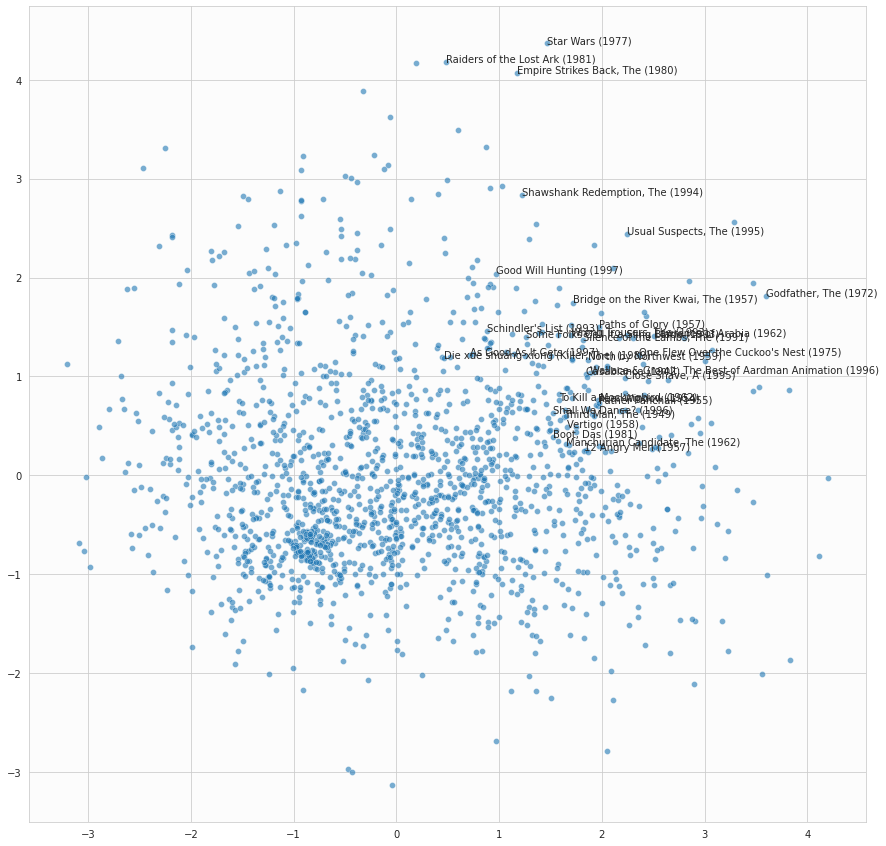

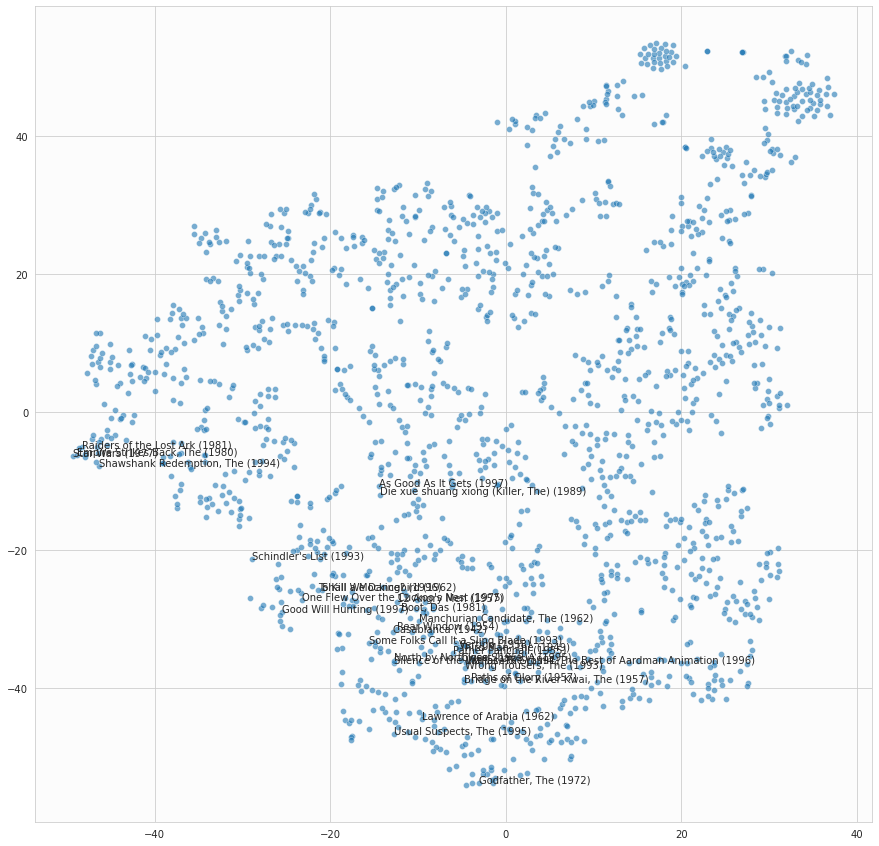

In [383]:
def plot_movies(movie_2d, idxs, named_movies, colors=None, alpha=.2):
    """
    This is a convenience fnction for plotting the embedded latent factors of movies, with 
    additional option for coloring using the cluster index etc..
    """
    
    # Create the figure
    plt.subplots(figsize=(15,15))
    
    # sns scatter...
    sns.scatterplot(x=movie_2d[idxs, 0], y=movie_2d[idxs, 1], 
                    hue=colors, alpha=alpha, palette=sns.color_palette("Paired", len(np.unique(colors))))
    
    # For the named movies we imprint their title:
    for idx in named_movies:
        plt.annotate(movie_title_df.loc[idx, 'title'], xy=(movie_2d[idx, :]))
    
    plt.show()
    
highlighted_movies = good_movies #popular_movies
plot_movies(lat_movie_pca, idxs, highlighted_movies, alpha=.6)
plot_movies(lat_movie_tsne, idxs, highlighted_movies, alpha=.6)

### Cluster in the tsne - since there seems to be more structure to it...: 

Cluster: 0
Mean of avg: 2.913, std: 0.406


,title,count,avg_rating
movie,,,
24,"Birdcage, The (1996)",290,3.441379
475,"First Wives Club, The (1996)",160,3.018750
357,Spawn (1997),143,2.615385
259,Event Horizon (1997),127,2.574803



Cluster: 1
Mean of avg: 4.074, std: 0.202


,title,count,avg_rating
movie,,,
257,Contact (1997),506,3.804348
99,Fargo (1996),473,4.147992
126,"Godfather, The (1972)",413,4.283293
55,Pulp Fiction (1994),394,4.060914



Cluster: 2
Mean of avg: 3.284, std: 0.314


,title,count,avg_rating
movie,,,
234,Mars Attacks! (1996),217,2.847926
318,Everyone Says I Love You (1996),168,3.273810
381,"Adventures of Priscilla, Queen of the Desert, The (1994)",107,3.560748
32,Desperado (1995),97,3.453608



Cluster: 3
Mean of avg: 3.908, std: 0.427


,title,count,avg_rating
movie,,,
287,Scream (1996),429,3.428904
0,Toy Story (1995),387,3.891473
317,Schindler's List (1993),298,4.466443
422,E.T. the Extra-Terrestrial (1982),295,3.844068



Cluster: 4
Mean of avg: 2.330, std: 0.198


,title,count,avg_rating
movie,,,
324,Crash (1996),128,2.546875
930,"Island of Dr. Moreau, The (1996)",57,2.157895
405,Thinner (1996),49,2.448980
947,Booty Call (1997),48,2.166667



Cluster: 5
Mean of avg: 3.878, std: 0.220


,title,count,avg_rating
movie,,,
6,Twelve Monkeys (1995),392,3.798469
150,Willy Wonka and the Chocolate Factory (1971),323,3.640867
215,When Harry Met Sally... (1989),290,3.910345
190,Amadeus (1984),276,4.163043



Cluster: 6
Mean of avg: 3.920, std: 0.362


,title,count,avg_rating
movie,,,
12,Mighty Aphrodite (1995),184,3.418478
513,Annie Hall (1977),179,3.910615
478,Vertigo (1958),179,4.251397
314,Apt Pupil (1998),160,4.100000



Cluster: 7
Mean of avg: 2.871, std: 0.274


,title,count,avg_rating
movie,,,
830,Escape from L.A. (1996),91,2.461538
1047,She's the One (1996),73,3.013699
1013,Romy and Michele's High School Reunion (1997),73,3.027397
736,Sirens (1994),59,2.983051



Cluster: 8
Mean of avg: 3.785, std: 0.520


,title,count,avg_rating
movie,,,
49,Star Wars (1977),583,4.358491
180,Return of the Jedi (1983),484,4.004132
293,Liar Liar (1997),457,3.144420
299,Air Force One (1997),431,3.631090



Cluster: 9
Mean of avg: 2.014, std: 0.090


,title,count,avg_rating
movie,,,
889,Mortal Kombat: Annihilation (1997),43,1.953488
1088,Speed 2: Cruise Control (1997),38,2.131579
1214,Barb Wire (1996),30,1.933333
563,Tales from the Hood (1995),27,2.037037



Cluster: 10
Mean of avg: 3.134, std: 0.368


,title,count,avg_rating
movie,,,
741,Ransom (1996),267,3.644195
322,Dante's Peak (1997),239,2.933054
677,Volcano (1997),219,2.808219
596,Eraser (1996),206,3.150485



Cluster: 11
Mean of avg: 3.841, std: 0.124


,title,count,avg_rating
movie,,,
285,"English Patient, The (1996)",481,3.656965
268,"Full Monty, The (1997)",315,3.926984
8,Dead Man Walking (1995),299,3.896321
474,Trainspotting (1996),250,3.884000



Cluster: 12
Mean of avg: 3.417, std: 0.370


,title,count,avg_rating
movie,,,
110,"Truth About Cats & Dogs, The (1996)",267,3.486891
195,Dead Poets Society (1989),249,3.911647
244,"Devil's Own, The (1997)",237,3.109705
283,Tin Cup (1996),193,3.160622



Cluster: 13
Mean of avg: 1.819, std: 0.263


,title,count,avg_rating
movie,,,
1229,Ready to Wear (Pret-A-Porter) (1994),18,1.833333
1335,Kazaam (1996),10,1.800000
1150,Original Gangstas (1996),7,2.142857
1249,Best of the Best 3: No Turning Back (1995),6,1.500000



Cluster: 14
Mean of avg: 3.147, std: 0.231


,title,count,avg_rating
movie,,,
366,Clueless (1995),170,3.458824
410,"Nutty Professor, The (1996)",163,2.914110
216,Bram Stoker's Dracula (1992),120,3.158333
678,Conan the Barbarian (1981),105,3.057143


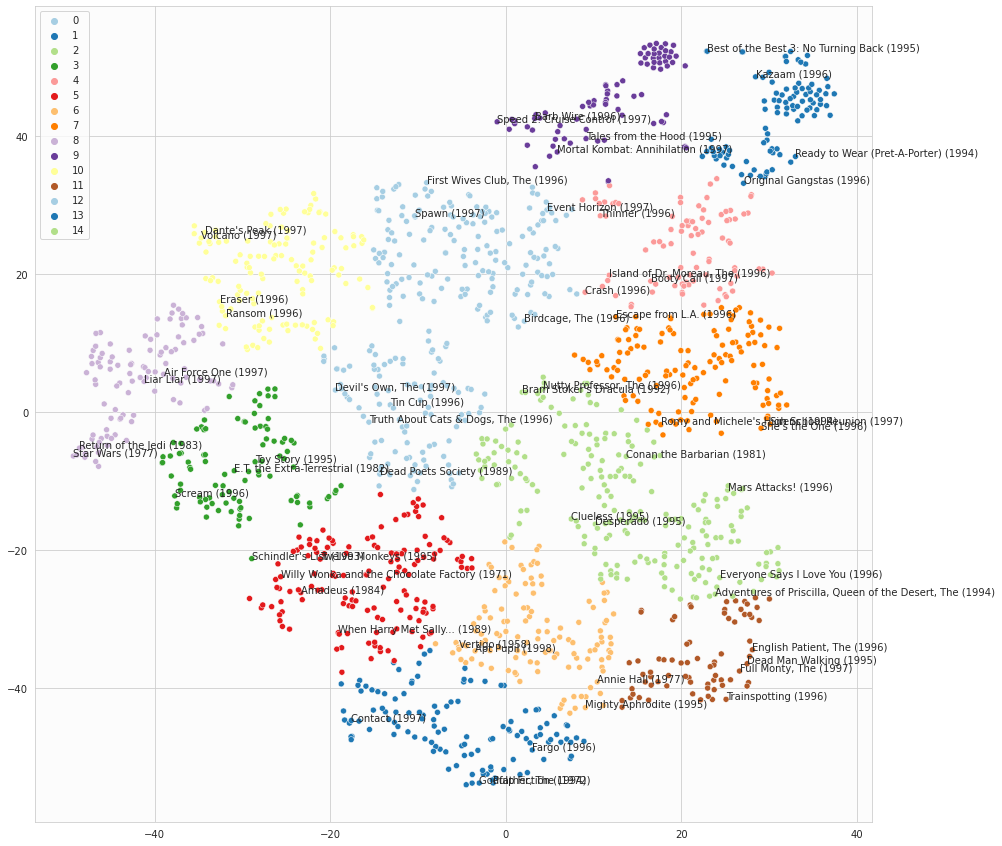

In [384]:
def get_clusters(clustering, X, print_report=False):
    """
    Convenience function for getting the most popular movies in each cluster.
    """
    clustering.fit(X, None)
    cl_movies = []
    
    # Loop over every cluster to get the most popular movies in that cluster...
    for cl_idx in np.unique(clustering.labels_):
        # Make a movie_df mask that can pick up the current cluster in the movie_title_df:
        mask = cl_idx == clustering.labels_
        
        # Use the avg_rating (created earlier) to sort the values in the cluster:
        cluster_df = movie_title_df.loc[mask, ['title', 'count', 'avg_rating']].sort_values('count', ascending=False)[:4]
        # Pick the 4 most popular movies:
        cl_movies.append(cluster_df.index)
    
        if print_report:
            print('Cluster: {}'.format(cl_idx))
            print('Mean of avg: {:.3f}, std: {:.3f}'.format(cluster_df.avg_rating.mean(), cluster_df.avg_rating.std()))
            display(cluster_df)
            print()

        
    
    return np.array(np.hstack(cl_movies)).flatten(), clustering.labels_

# Import the clustering methods:
from sklearn.cluster import KMeans

n_clusters=15

# Create the KMeans clustering class:
clustering = KMeans(n_clusters, init='k-means++')

X = lat_movie_tsne
cl_movies, cl_labels = get_clusters(clustering, X, True)
plot_movies(X, idxs, cl_movies, cl_labels, alpha=1)

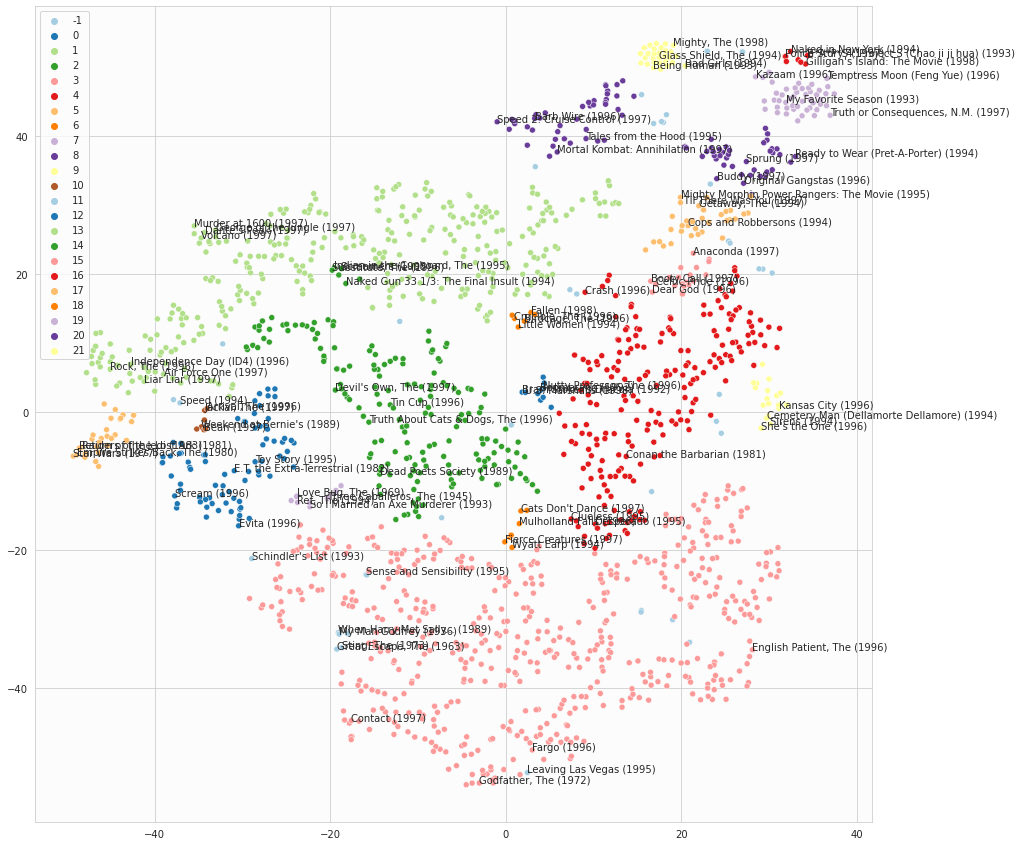

In [385]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=2.5) 
cl_movies, cl_labels = get_clusters(clustering, X)
plot_movies(X, idxs, cl_movies, cl_labels, alpha=1)

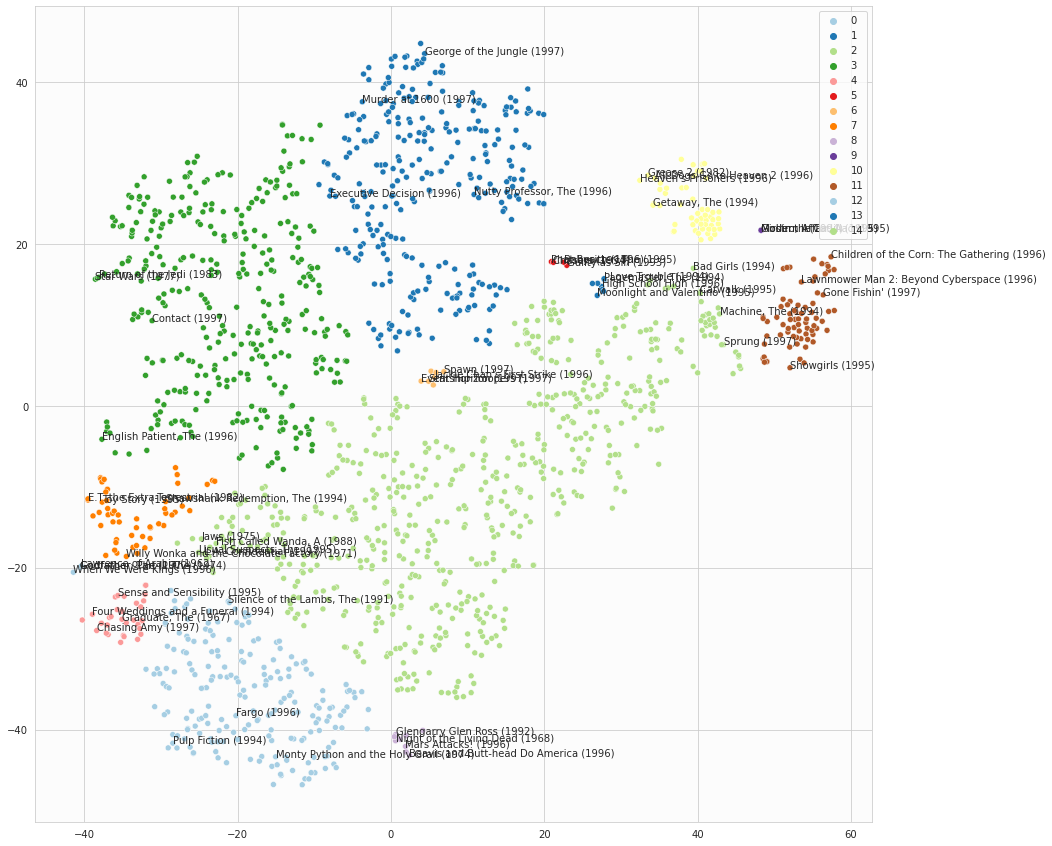

In [375]:
from sklearn.cluster import SpectralClustering

cl_movies, cl_labels = get_clusters(SpectralClustering(n_clusters), X)
plot_movies(X, idxs, cl_movies, cl_labels, alpha=1)

### Suggested exercises:
1. Modify the loss so that mis prediction on a popular title would be more serious than on a unpopular one.
2. Try to device a regularization that would push as many of the latent factors to zero as possible.
3. Why are 'good movies' so close to each other in the tsne mapping?
4. Explain how, KMeans and DBscan work.


## Collab filtering using fastai:

,user,title,rating
0,159,Smoke (1995),5
1,345,Die Hard 2 (1990),3
2,478,"Room with a View, A (1986)",4
3,931,Lawrence of Arabia (1962),5
4,905,Lone Star (1996),4
5,882,M*A*S*H (1970),5
6,49,"Frighteners, The (1996)",4
7,464,Hearts and Minds (1996),2
8,575,Jerry Maguire (1996),4
9,302,Ace Ventura: When Nature Calls (1995),2


SuggestedLRs(lr_min=0.02089296132326126, lr_steep=2.75422871709452e-06)

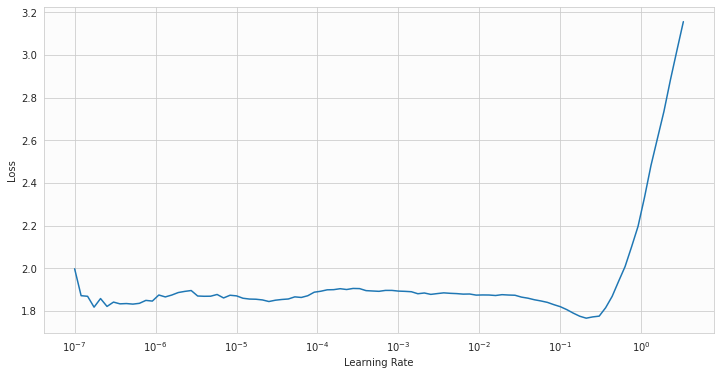

In [21]:
from fastai.collab import *
from fastai.tabular.all import *


dls = CollabDataLoaders.from_df(df.loc[:, ['user', 'title', 'rating']], item_name='title', bs=128)

n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])

dls.show_batch()

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

learn.lr_find()

In [22]:
learn.fit_one_cycle(5, 2e-3)

epoch,train_loss,valid_loss,time
0,1.152455,1.046522,00:03
1,0.893091,0.875706,00:03
2,0.809367,0.840528,00:03
3,0.730330,0.830249,00:03
4,0.704221,0.829167,00:03


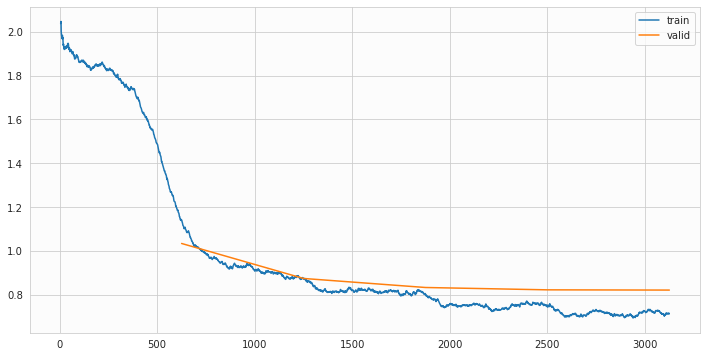

In [33]:
learn.recorder.plot_loss()

In [34]:
learn.fit_one_cycle(5, 2e-3, wd=.1)

epoch,train_loss,valid_loss,time
0,0.718682,0.823375,00:02
1,0.705631,0.810626,00:02
2,0.624485,0.804164,00:02
3,0.549460,0.804093,00:02
4,0.522071,0.804570,00:02


In [35]:
movie_bias = learn.model.movie_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[(movie_bias[i], dls.classes['title'][i]) for i in idxs]

[(tensor(0.4774, device='cuda:0', grad_fn=<SelectBackward>), 'Titanic (1997)'),
 (tensor(0.4468, device='cuda:0', grad_fn=<SelectBackward>),
  'L.A. Confidential (1997)'),
 (tensor(0.4236, device='cuda:0', grad_fn=<SelectBackward>),
  'Silence of the Lambs, The (1991)'),
 (tensor(0.4082, device='cuda:0', grad_fn=<SelectBackward>),
  'Shawshank Redemption, The (1994)'),
 (tensor(0.3939, device='cuda:0', grad_fn=<SelectBackward>),
  "Schindler's List (1993)")]

# Utils:

In [75]:
from torch import tensor, nn
import torch 
import os


def init_params(size): return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

def update_params(params, lr):
    # Very simple gradient descent step
    params.data -= lr * params.grad.data
    # In pytorch you need to 
    # https://pytorch.org/docs/stable/autograd.html#default-grad-layouts
    #params.grad.detach_()
    #params.grad.zero_()
    params.grad = None

class DotBase():
    
    def __init__(self, users_shape, movies_shape, X, use_bias=False, lr=.1):
    
        self.use_bias = use_bias
        self.x = X
        self.lr = lr
        
        try:
            self.load(users_shape, movies_shape)
        except FileNotFoundError as e:
            print('Not found')
            self.lat_users = init_params(users_shape)
            self.lat_movies = init_params(movies_shape)
            self.bias_users = init_params((users_shape[0], ))
            self.bias_movies = init_params((movies_shape[0], ))
        
    
    def update_lat(self, bs=64):
        """
        Update the latend factors using learning_rate lr.
        """
        lr = self.lr
        for i in range(int(len(self.x)/bs)):
            # Perform sgd using batch size bs 
            loss = self.get_loss(self.x[i*bs: (i+1)*bs, :])
            loss.backward()

            update_params(self.lat_users, lr)
            update_params(self.lat_movies, lr)
            if self.use_bias:
                update_params(self.bias_users, lr)
                update_params(self.bias_movies, lr)
        
        return loss
    
    def get_params(self, idxs, key='user'):
        if key=='user':
            lat = self.lat_users[idxs]
            bias = self.bias_users[idxs]
        elif key=='movie':
            lat = self.lat_movies[idxs]
            bias = self.bias_movies[idxs]
        
        if self.use_bias: return lat, bias
        else: return lat
    
    def save(self):
        if not os.path.exists('params/'): 
            os.makedirs('params/')
            
        torch.save(self.lat_users, 'params/lat_users_{}_{}_bias={}.to'.format(*self.lat_users.shape, self.use_bias))
        torch.save(self.lat_movies, 'params/lat_movies_{}_{}_bias={}.to'.format(*self.lat_movies.shape, self.use_bias))
        torch.save(self.bias_users, 'params/bias_users_{}_{}_bias={}.to'.format(*self.lat_users.shape, self.use_bias))
        torch.save(self.bias_movies, 'params/bias_movies_{}_{}_bias={}.to'.format(*self.lat_movies.shape, self.use_bias))

    def load(self, users_shape, movies_shape):
        self.lat_users = torch.load('params/lat_users_{}_{}_bias={}.to'.format(*users_shape, self.use_bias))
        self.lat_movies = torch.load('params/lat_movies_{}_{}_bias={}.to'.format(*movies_shape, self.use_bias))
        self.bias_users = torch.load('params/bias_users_{}_{}_bias={}.to'.format(*users_shape, self.use_bias))
        self.bias_movies = torch.load('params/bias_movies_{}_{}_bias={}.to'.format(*movies_shape, self.use_bias))



In [ ]:
# 3d pca...
from sklearn.decomposition import PCA

N = 3000
D = 6

# Create the data:
data=np.zeros((N, 3))
data[:N//2, 0] = np.random.normal(loc=D, size=N//2)
data[N//2:, 0] = np.random.normal(loc=-D, size=N//2)
data[:, 1] = np.random.normal(loc=0, scale=3, size=N)
data[:, 2] = np.random.normal(loc=0, scale=1, size=N)

# Imaginary classes:
cl = np.zeros(N, dtype=bool)
cl[N//2:] = 1


# Rotate the data:

# Rotation angle
phi = np.pi/9

# Rotation matrix
R = np.array([[np.cos(phi), -np.sin(phi), 0],
              [np.sin(phi), np.cos(phi), 0],
              [0, 0, 1]])

# Rotated_data:
data = (R@(data.T)).T

# Shift
data -= data.mean(axis=0)

# The principal components are the eigenvectors of the covariance matrix...
eig, eig_vec = np.linalg.eig(np.cov(data.T))
#print(eig[eig.argsort()])
#print(eig_vec[:, eig.argsort()])

# Use PCA to find the pricipal components:
pca = PCA(n_components=3).fit(data)


fig = plt.figure(figsize=(18,6)) #subplots(1,3)
ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

# Original and components:
ax1.scatter(data[:, 0], data[:, 1], data[:, 2], c=['C{}'.format(c.astype(int)) for c in cl], alpha = .2) #, colors=cl)
for i, color, expl_var, pca_comp in zip(range(3), ['g', 'r', 'b'], pca.explained_variance_, pca.components_):
    #print(expl_var)
    #print(pca_comp)
    ax1.quiver(0, 0, 0, *(pca_comp*np.sqrt(expl_var)), color=color, label='pca {}'.format(i+1))
ax1.set_title('Data')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax1.set_zlabel('z')
ax1.legend()
#ax1.axis('equal')

# Transformed:
pca_data = pca.transform(data)
ax2 = sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], ax=ax2, hue=cl)
ax2.set_title('After pca transformation')
ax2.set_xlabel('Pca component 1')
ax2.set_ylabel('Pca component 2')
ax2.axis('equal')

# Dim reduced:
ax3 = sns.histplot(x=pca_data[:, 0], hue=cl, ax=ax3, bins=50)
ax3 = sns.scatterplot(x=pca_data[:, 0], y=np.ones(N)*-1, hue=cl, ax=ax3)
ax3.set_title('After pca transformation + dim red.')
ax3.set_xlabel('Pca component 1')
plt.show()